In [1]:
import numpy as np
import sys
sys.path.append('../main/')
from multi_py.multi import *
# from multi_py.atmos import atmos
import matplotlib.pyplot as plt
import copy
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as ndi
plt.style.use('../main/multi_py/Bergemann2020.mplstyle')

In [2]:
# test_atmos = atmos(parent='../runs/SiStagNLTE_30_f3Dold/', file='multi3d.input')

In [3]:
major_krs = [286, 291, 293, 299, 427]
run_3DNLTE = m3d('../runs/SiStagNLTE_30_f3Dold/output/', lines=major_krs, conts=[], ratmos=True)
run_1DNLTE = m3d('../runs/SiMarcs1DNLTE/output/', lines=major_krs, conts=[], ratmos=True)

Completed reading parameters from ../runs/SiMarcs1DNLTE/output//


In [4]:
atmo_3DNLTE = run_3DNLTE.atmos
atmo_1DNLTE = run_1DNLTE.atmos

In [5]:
# Geometric spacing of gridpoints:
dz_1D = np.abs((run_1DNLTE.widthz[0] - run_1DNLTE.widthz[-1])/(run_1DNLTE.nz - 1))
dy_1D = dx_1D  = np.abs((run_1DNLTE.widthx[0] - run_1DNLTE.widthx[-1])/(run_1DNLTE.nx - 1))


(-6.0, 4.0)

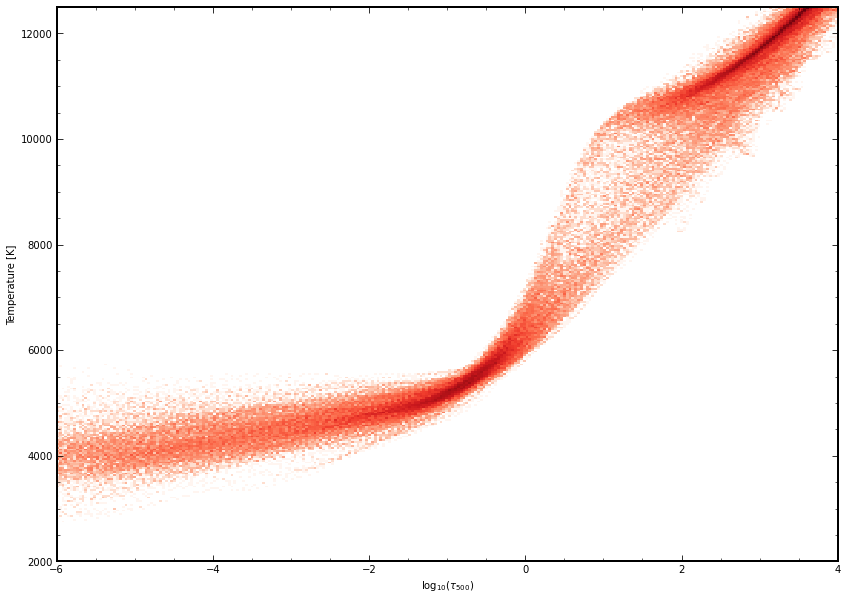

In [6]:
fig, ax = plt.subplots(1, figsize=(14,10), sharey='row')
atmo_3DNLTE.hist2d(ax=ax, cmap='Reds', nbins=300);
# ax.set_title('3D')
ax.set_ylabel('Temperature [K]' )
ax.set_xlim(-6)
# atmo_1DNLTE.hist2d(ax=ax[1]);
# ax[1].set_title('1D')
# fig.savefig('../plots/Stagger_temphist2.png')

Text(0.5, 1.0, '1DNLTE')

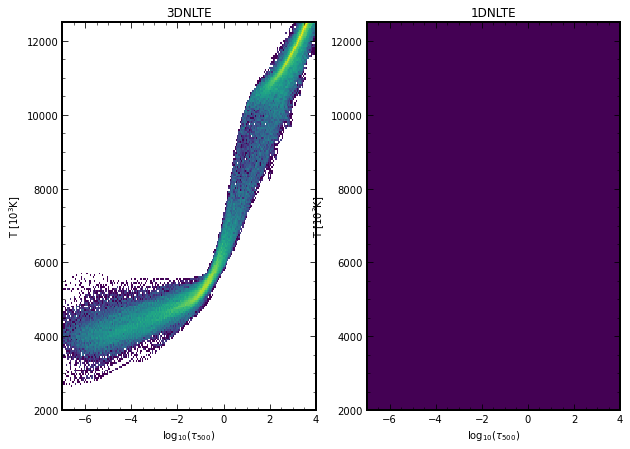

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,7), sharey='row')
atmo_3DNLTE.hist2d(ax=ax[0]);
ax[0].set_title('3DNLTE')
atmo_1DNLTE.hist2d(ax=ax[1]);
ax[1].set_title('1DNLTE')

In [8]:
np.shape(atmo_3DNLTE.tau)

(30, 30, 230)

In [9]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    return az, el, r

In [10]:
atmo_1DNLTE.cart = [i for i in np.ndindex(np.shape(atmo_1DNLTE.temp))]

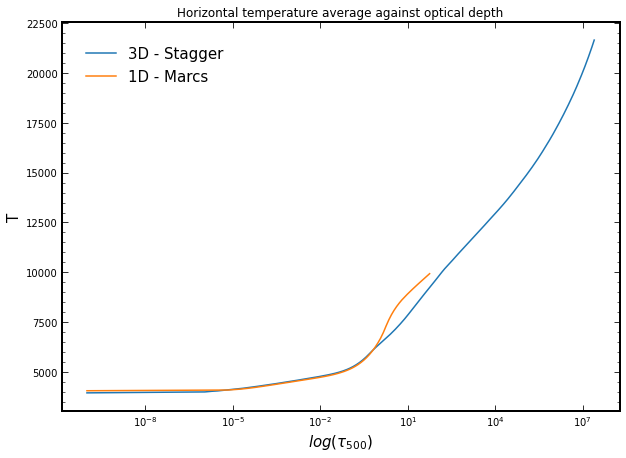

In [11]:
fig, ax = plt.subplots(1, figsize=(10,7), sharey='row')
ax.semilogx(atmo_3DNLTE.hav('tau'), atmo_3DNLTE.hav('temp'), label='3D - Stagger')
ax.semilogx(atmo_1DNLTE.hav('tau'), atmo_1DNLTE.hav('temp'), label='1D - Marcs')
ax.set_xlabel(r'$log(\tau_{500})$', fontsize=15)
ax.set_ylabel('T', fontsize=15)
ax.set_title('Horizontal temperature average against optical depth')
ax.legend(fontsize=15)

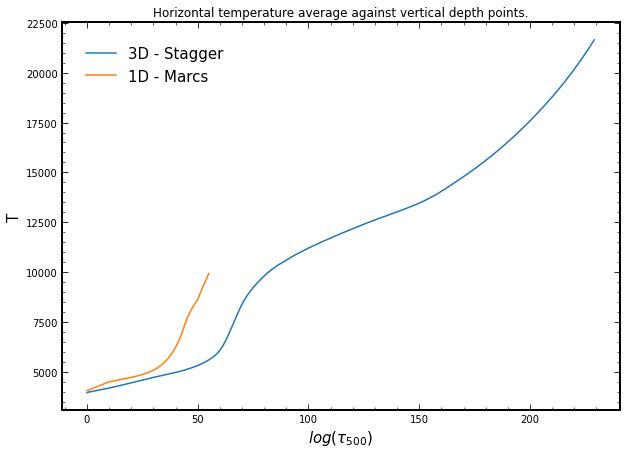

In [12]:
fig, ax = plt.subplots(1, figsize=(10,7), sharey='row')
ax.plot(atmo_3DNLTE.hav('temp'), label='3D - Stagger')
ax.plot(atmo_1DNLTE.hav('temp'), label='1D - Marcs')
ax.set_xlabel(r'$log(\tau_{500})$', fontsize=15)
ax.set_ylabel('T', fontsize=15)
ax.set_title('Horizontal temperature average against vertical depth points.')
ax.legend(fontsize=15)

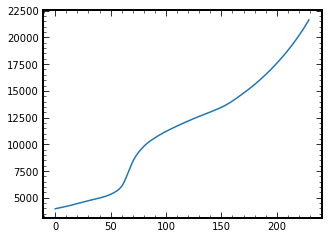

In [13]:
plt.plot(atmo_3DNLTE.hav('temp'))

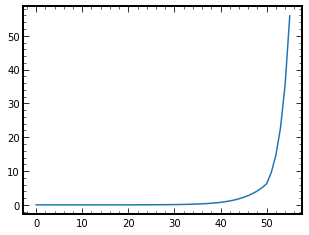

In [14]:
plt.plot(atmo_1DNLTE.hav('tau'))

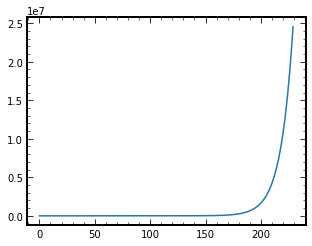

In [15]:
plt.plot(atmo_3DNLTE.hav('tau'))

In [16]:
phi = np.pi/2
def f(x, y):
    return np.abs(x*np.cos(phi))

x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

In [17]:
print(f(x,y))

[0.00000000e+00 6.80359333e-18 1.36071867e-17 2.04107800e-17
 2.72143733e-17 3.40179666e-17 4.08215600e-17 4.76251533e-17
 5.44287466e-17 6.12323400e-17]


/tmp/ipykernel_42354/3229922665.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


(0.0, 5.0)

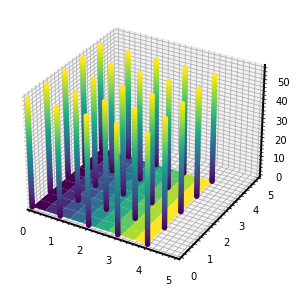

In [18]:
# %matplotlib widget
fig = plt.figure()
ax = Axes3D(fig)
data = atmo_1DNLTE.temp
x, y, z = data.nonzero()
ax.scatter(x, y, z, c=z, alpha=1)
ax.plot_surface(X*4, Y*4, Z*55, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_zlim(0,56)
ax.set_xlim(0,5)
ax.set_ylim(0,5)



In [19]:
4*np.tan(np.pi/3)

6.928203230275507

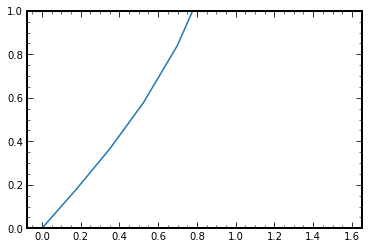

In [20]:
%matplotlib inline
x = np.linspace(0,np.pi/2, 10)
plt.plot(x, np.tan(x))
plt.ylim(0,1)
plt.show()

In [21]:
# fig = plt.figure(figsize=(10,10))
# ax= fig.add_subplot(111, projection='3d')
# data = atmo_3DNLTE.tau
# x, y, z = data.nonzero()
# ax.scatter(x, y, z, c=z, alpha=1)

## map coords

In [22]:
def intp_plane(dx, dy, dz, atmosobject, runobject):
    x_max = np.max(runobject.widthz)
    scaling = np.array([dx, dy, dz])
    data = atmosobject.temp
    u = np.array([0, 1 ,0])
    v = np.array([1, 0, 0.203])
    coords = (u[:, None, None] * np.linspace(0, x_max, 20)[None, :, None] +
          v[:, None, None] * np.linspace(0, (x_max)/np.cos(0.201), 20)[None, None, :])
    idx = coords / scaling[(slice(None),) + (None,)*(coords.ndim-1)]
    print(data.shape, coords.shape)
    new_data = ndi.map_coordinates(data, idx)
    return new_data


In [23]:
new_plane = intp_plane(dx_1D, dy_1D, dz_1D, atmo_1DNLTE, runobject=run_1DNLTE)

(5, 5, 56) (3, 20, 20)


In [24]:
np.array([dx_1D, dy_1D, dz_1D])

array([1000000.        , 1000000.        , 1484545.45454545])

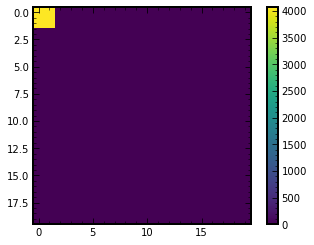

In [25]:
im=plt.imshow(new_plane)
plt.colorbar(im)

In [26]:
# new_data = new_data[new_data>0]
# plt.imshow(new_data)

In [27]:
# new_data_row = new_data[0]
# plt.plot(new_data_row[new_data_row>0])

In [28]:
# clean_data = new_data[~np.all(new_data == 0, axis=1)]
# clean_data = new_data[~np.all(clean_data == 0, axis=0)]


In [29]:
run_3DNLTE.widthx[0] - run_3DNLTE.widthx[-1]

-796666688.0

In [30]:
np.tan(0.201)*(run_3DNLTE.widthx[0] - run_3DNLTE.widthx[-1])

-162321903.85647488

## Averaged y temps

In [31]:
def temp_path(runobject):
    atmosobject = runobject.atmos
    # (ave) grid separation
    dz = np.abs((runobject.widthz[0] - runobject.widthz[-1])/(runobject.nz - 1))
    dy = dx  = np.abs((runobject.widthx[0] - runobject.widthx[-1])/(runobject.nx - 1))

    y_mean_temp = np.mean(atmosobject.temp, axis=1)
    y_mean_tau500 = np.mean(atmosobject.tau, axis=1)
    y_mean_rho = np.mean(atmosobject.rho, axis=1)
    
    xx = np.linspace(0,atmosobject.nx-1,50)
    h = (xx*dx)/(np.cos(0.201))
    zz = xx*(dx/dz)*np.tan(0.201)
    zz_array = zz

    h_array = copy.deepcopy(h)

    i=1
    while np.max(zz+zz[-1]*i) < atmosobject.nz-1:
            zz_array = np.vstack([zz_array,zz+zz[-1]*i])
            h_array = np.vstack([h_array, h+h[-1]*i])
            i+=1


    tt_array = np.zeros(zz_array.shape)
    od_array = np.zeros(zz_array.shape)
    rho_array = np.zeros(zz_array.shape)
    z_real = np.zeros(zz_array.shape)
    for s, thiszz in enumerate(zz_array):
        grid_coords = np.column_stack((xx,thiszz))
        # Interpolate the temperature, optical depth, and density at these grid points
        tt_array[s] = ndi.map_coordinates(y_mean_temp, grid_coords.T)
        od_array[s] = ndi.map_coordinates(y_mean_tau500, grid_coords.T)
        rho_array[s] = ndi.map_coordinates(y_mean_rho, grid_coords.T)
        z_real[s] = thiszz*dz

    # path distance from bottom of cube for mu = 1 for each grid point
    ray_dist_mu1 = runobject.widthz - runobject.widthz[-1]
    ray_dist_mu1 = ray_dist_mu1[::-1]
    # print(z_real)
    # print(runobject.widthz[0] - runobject.widthz[-1])
    # print(np.shape(tt_array))

    return h_array, tt_array, od_array, rho_array, ray_dist_mu1, atmosobject.hav('temp'), atmosobject.hav('tau'), atmosobject.hav('rho')

In [32]:
h_array_1D, tt_array_1D, od_array_1D, rho_array_1D, ray_dist_mu1_1D,  temp_hav_1D, od_hav_1D, rho_hav_1D = temp_path(run_1DNLTE)

In [33]:
h_array_3D, tt_array_3D, od_array_3D, rho_array_3D, ray_dist_mu1_3D, temp_hav_3D, od_hav_3D, rho_hav_3D = temp_path(run_3DNLTE)

In [34]:
od_array_3D

array([[1.00000001e-10, 1.28264696e-06, 4.03553895e-06, 9.27921701e-06,
        1.86200468e-05, 3.45505978e-05, 6.32132505e-05, 1.04831430e-04,
        1.58688359e-04, 2.56717060e-04, 4.69756749e-04, 8.86844820e-04,
        1.60910736e-03, 2.74089281e-03, 4.49977163e-03, 7.23126391e-03,
        1.07467966e-02, 1.46509362e-02, 1.92469005e-02, 2.52735969e-02,
        3.34567018e-02, 4.42239009e-02, 5.79408109e-02, 7.51478970e-02,
        1.03475519e-01, 1.52883872e-01, 2.22879335e-01, 3.15347791e-01,
        4.24046159e-01, 5.17986298e-01, 6.80473566e-01, 3.26347184e+00,
        1.10935469e+01, 1.85015373e+01, 2.41236820e+01, 3.73581009e+01,
        5.69929581e+01, 7.60744019e+01, 9.00456696e+01, 1.11189987e+02,
        1.58881363e+02, 2.02686172e+02, 2.34325623e+02, 2.84189575e+02,
        3.44133514e+02, 4.11244537e+02, 5.09731995e+02, 6.64902771e+02,
        9.11666748e+02, 1.15431689e+03],
       [1.16154150e+03, 1.28261926e+03, 1.48414807e+03, 1.83548596e+03,
        2.09617114e+03,

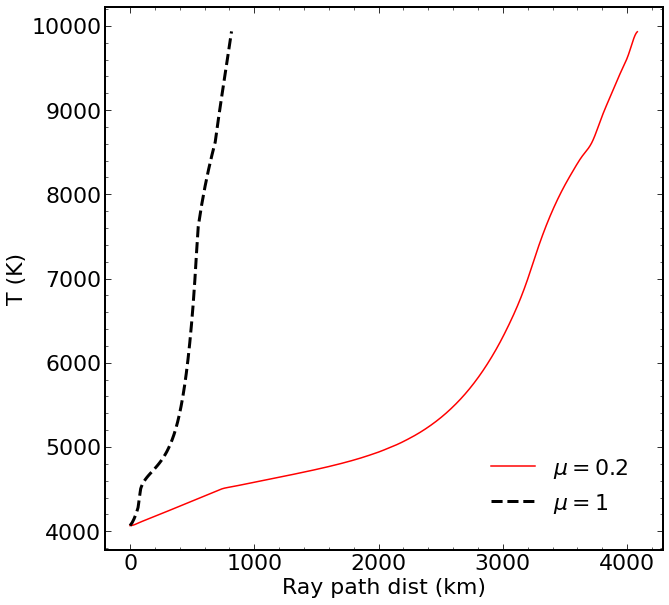

In [35]:
matplotlib.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(h_array_1D.ravel()* 1e-5, tt_array_1D.ravel(), label='$\mu = 0.2$', color='r')
ax.plot(ray_dist_mu1_1D * 1e-5,temp_hav_1D, label='$\mu = 1$', color='k' , linestyle='--', linewidth=3)

ax.set_ylabel('T (K)')
ax.set_xlabel('Ray path dist (km)')
# ax.set_title('1D atmosphere')
ax.legend()
# fig.savefig('../plots/1D_temp_raydist.png')

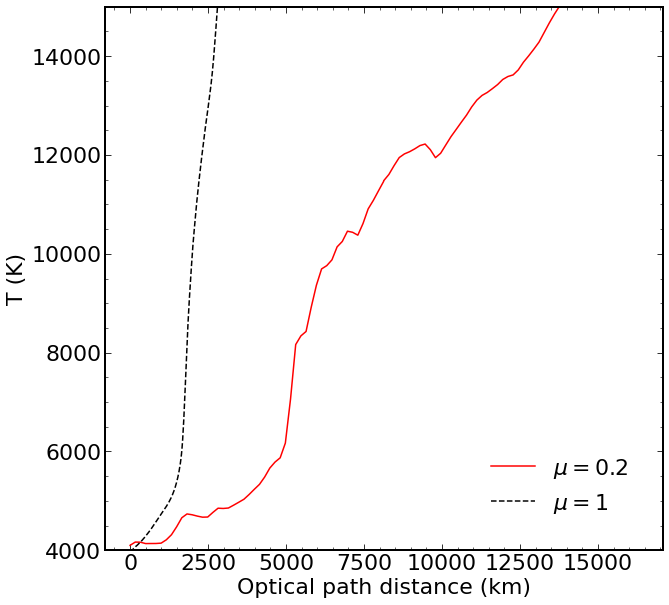

In [36]:
matplotlib.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(h_array_3D.ravel()* 1e-5, tt_array_3D.ravel(), label='$\mu = 0.2$', color='r')
ax.plot(ray_dist_mu1_3D * 1e-5,temp_hav_3D,  label='$\mu = 1$', color='k' , linestyle='--')
ax.set_ylabel('T (K)')
ax.set_xlabel('Optical path distance (km)')
# ax.set_title('3D atmosphere')
ax.set_ylim(4000, 15000)

ax.legend()
# fig.savefig('../plots/3D_temp_raydist.png')

## Plot per mu angle

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

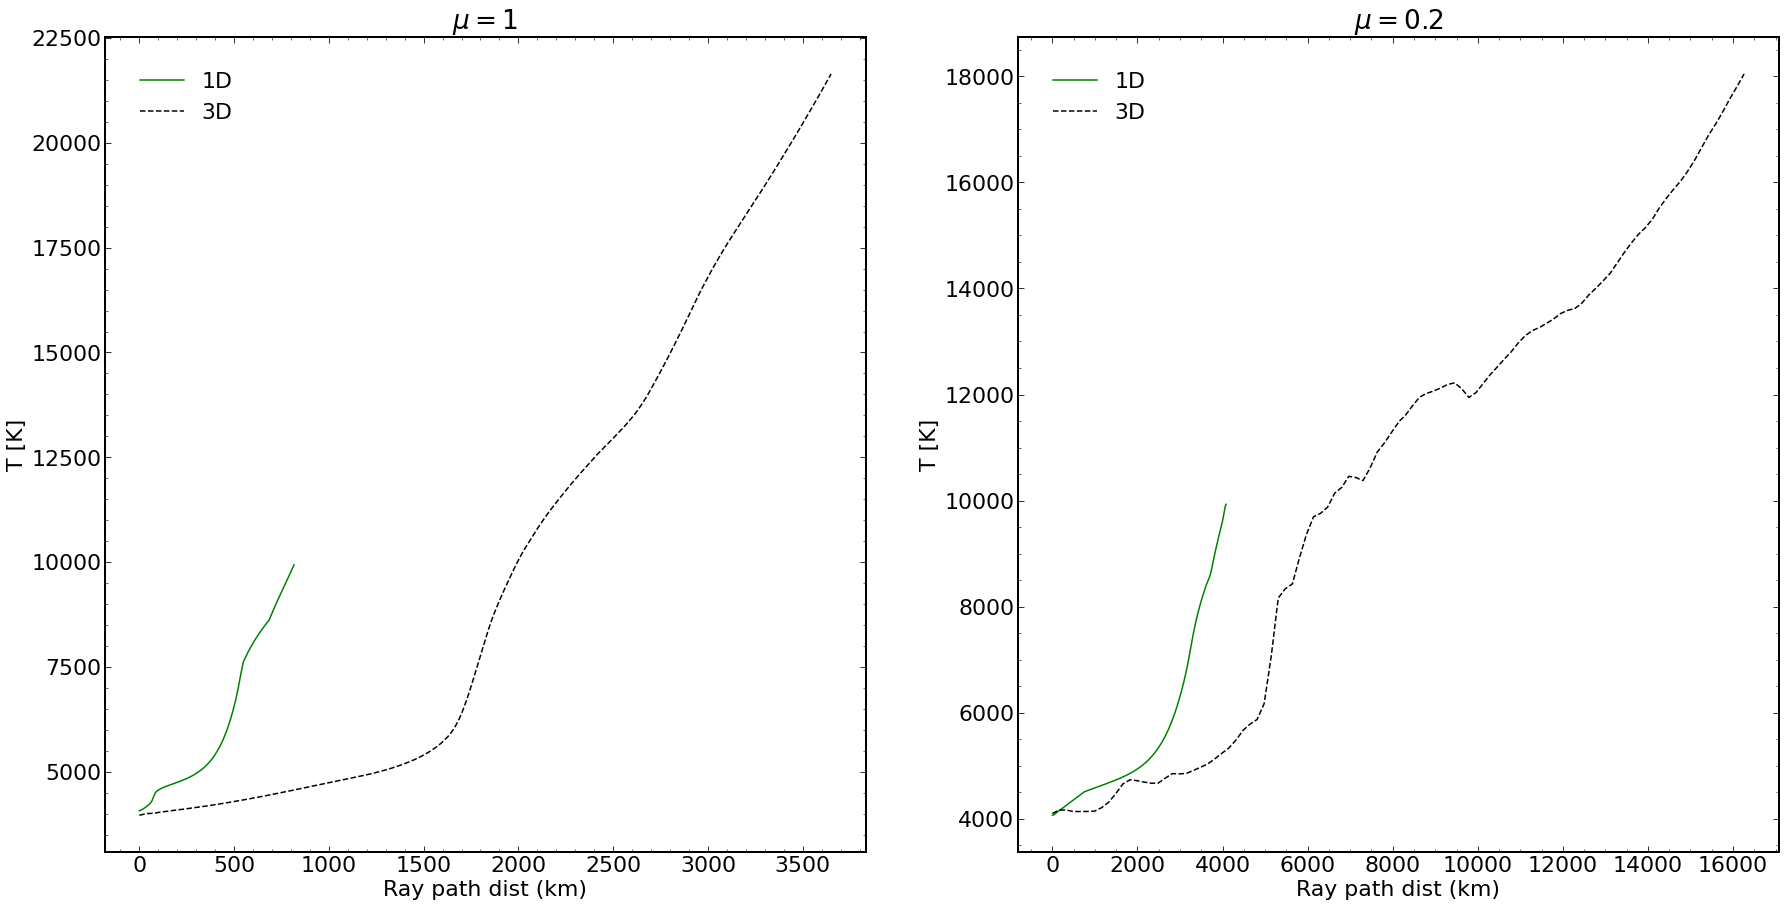

In [37]:
fig, ax = plt.subplots(1,2 , figsize=(30,15))
ax[0].plot(ray_dist_mu1_1D * 1e-5 ,temp_hav_1D, label='1D', color='g' , linestyle='-')
ax[0].plot(ray_dist_mu1_3D * 1e-5 ,temp_hav_3D,  label='3D', color='k' , linestyle='--')
ax[0].set_ylabel('T [K]')
ax[0].set_xlabel('Ray path dist (km)')
ax[0].set_title('$\mu = 1$')
ax[0].legend()

ax[1].plot(h_array_1D.ravel() * 1e-5 ,tt_array_1D.ravel(), label='1D', color='g' , linestyle='-')
ax[1].plot(h_array_3D.ravel() * 1e-5 ,tt_array_3D.ravel(),  label='3D', color='k' , linestyle='--')
ax[1].set_ylabel('T [K]')
ax[1].set_xlabel('Ray path dist (km)')
ax[1].set_title('$\mu = 0.2$')
ax[1].legend()

plt.tight_layout


In [38]:
od_array_3D.ravel().shape

(100,)

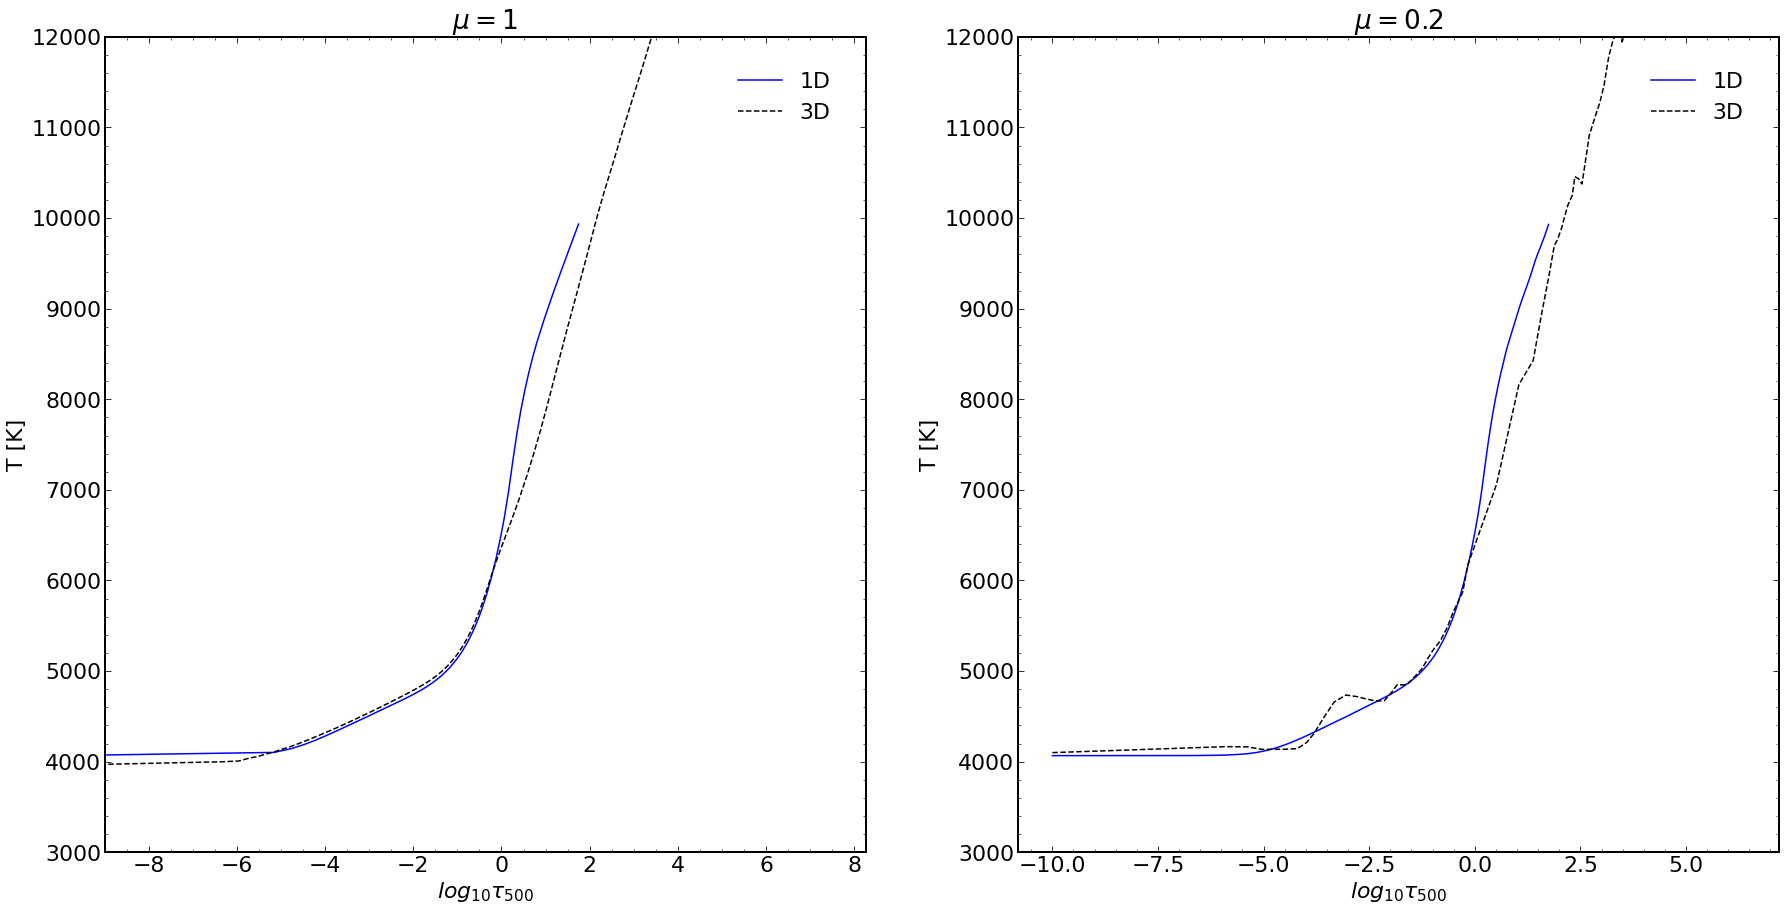

In [39]:
fig, ax = plt.subplots(1,2 , figsize=(30,15))
ax[0].plot(np.log10(od_hav_1D) ,temp_hav_1D, label='1D', color='b' , linestyle='-')
ax[0].plot(np.log10(od_hav_3D), temp_hav_3D,  label='3D', color='k' , linestyle='--')
ax[0].set_xlabel(r'$log_{10}\tau_{500}$')
ax[0].set_ylabel('T [K]')
ax[0].set_title('$\mu = 1$')
ax[0].set_ylim(3000,12000)
ax[0].set_xlim(-9)

ax[0].legend()

ax[1].plot(np.log10(od_array_1D.ravel()), tt_array_1D.ravel(), label='1D', color='b' , linestyle='-')
ax[1].plot(np.log10(od_array_3D.ravel()), tt_array_3D.ravel(), label='3D', color='k' , linestyle='--')
ax[1].set_xlabel(r'$log_{10}\tau_{500}$')
ax[1].set_ylabel('T [K]')
ax[1].set_title('$\mu = 0.2$')
ax[1].set_ylim(3000,12000)
ax[0].set_xlim(-9)

# ax[1].xticks(np.arange(min(x), max(x)+1, 1.0))



ax[1].legend()

### tau adjust

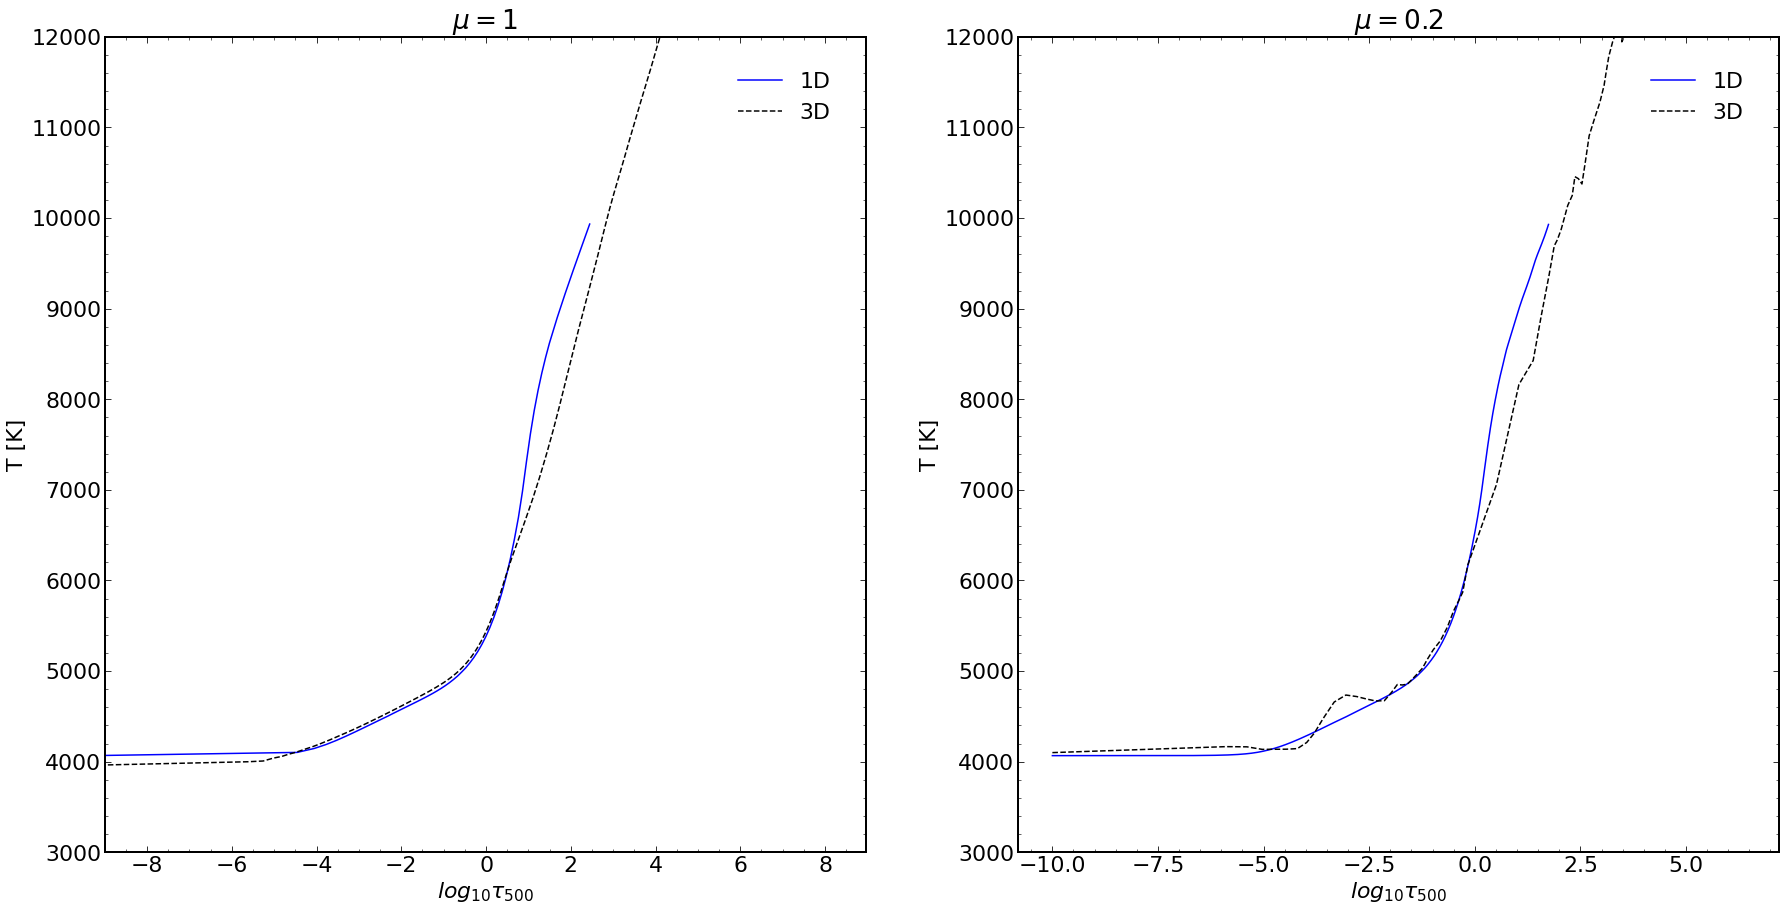

In [40]:
fig, ax = plt.subplots(1,2 , figsize=(30,15))
ax[0].plot(np.log10(od_hav_1D/0.2) ,temp_hav_1D, label='1D', color='b' , linestyle='-')
ax[0].plot(np.log10(od_hav_3D/0.2), temp_hav_3D,  label='3D', color='k' , linestyle='--')
ax[0].set_xlabel(r'$log_{10}\tau_{500}$')
ax[0].set_ylabel('T [K]')
ax[0].set_title('$\mu = 1$')
ax[0].set_ylim(3000,12000)
ax[0].set_xlim(-9)

ax[0].legend()

ax[1].plot(np.log10(od_array_1D.ravel()), tt_array_1D.ravel(), label='1D', color='b' , linestyle='-')
ax[1].plot(np.log10(od_array_3D.ravel()), tt_array_3D.ravel(), label='3D', color='k' , linestyle='--')
ax[1].set_xlabel(r'$log_{10}\tau_{500}$')
ax[1].set_ylabel('T [K]')
ax[1].set_title('$\mu = 0.2$')
ax[1].set_ylim(3000,12000)
ax[0].set_xlim(-9)

# ax[1].xticks(np.arange(min(x), max(x)+1, 1.0))



ax[1].legend()

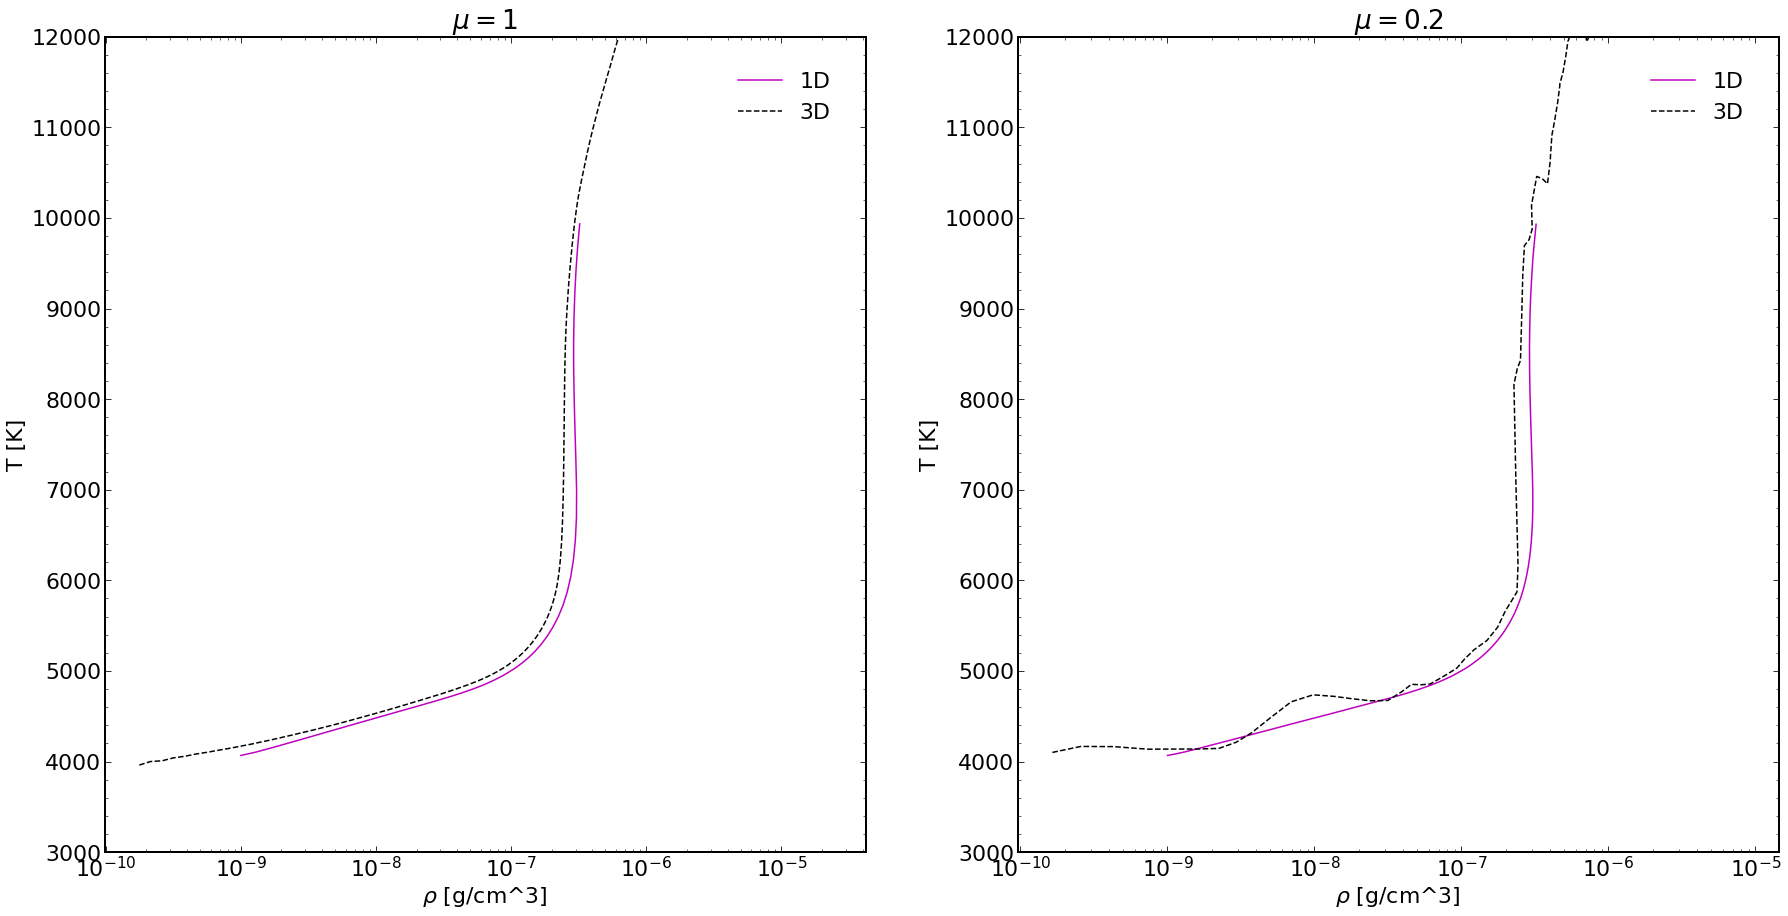

In [41]:
fig, ax = plt.subplots(1,2 , figsize=(30,15))
ax[0].semilogx(rho_hav_1D ,temp_hav_1D, label='1D', color='m' , linestyle='-')
ax[0].semilogx(rho_hav_3D ,temp_hav_3D,  label='3D', color='k' , linestyle='--')
ax[0].set_xlabel(r'$\rho$ [g/cm^3]')
ax[0].set_ylabel('T [K]')
ax[0].set_title('$\mu = 1$')
ax[0].set_ylim(3000,12000)
ax[0].legend()

ax[1].semilogx(rho_array_1D.ravel(), tt_array_1D.ravel(), label='1D', color='m' , linestyle='-')
ax[1].semilogx(rho_array_3D.ravel(),  tt_array_3D.ravel(), label='3D', color='k' , linestyle='--')
ax[1].set_xlabel(r'$\rho$ [g/cm^3]')
ax[1].set_ylabel('T [K]')
ax[1].set_title('$\mu = 0.2$')
ax[1].set_ylim(3000,12000)

ax[1].legend()

In [42]:
1/np.sin(0.2)

5.033489547672344

## 1D Plots

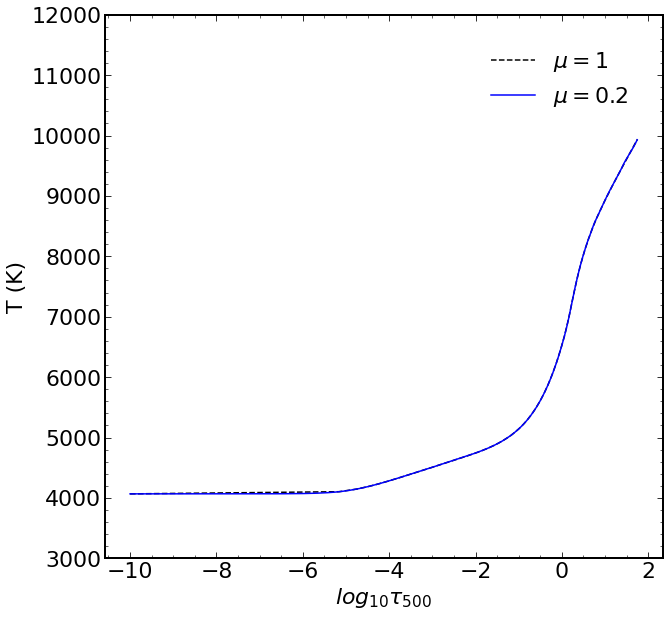

In [43]:
matplotlib.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(np.log10(od_hav_1D) ,temp_hav_1D, label='$\mu = 1$', color='k' , linestyle='--')
ax.plot(np.log10(od_array_1D.ravel()), tt_array_1D.ravel(), label='$\mu = 0.2$', color='b' , linestyle='-')

ax.set_xlabel(r'$log_{10}\tau_{500}$')
ax.set_ylim(3000,12000)

ax.set_ylabel('T (K)')
ax.legend()


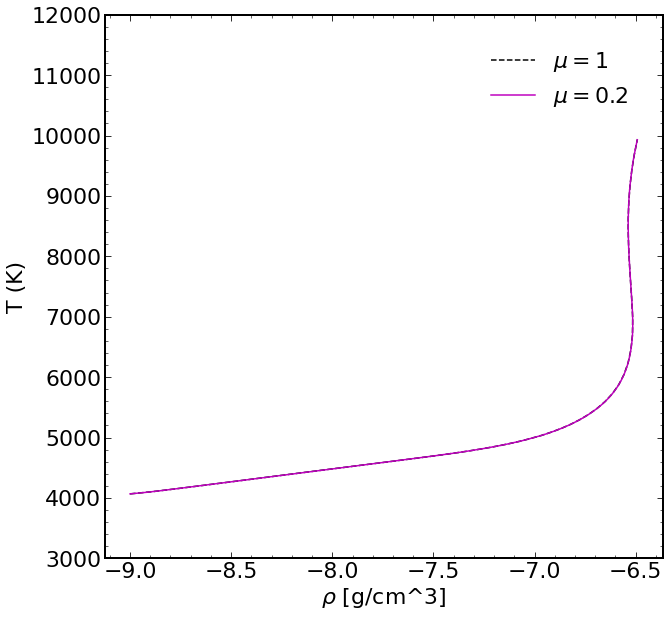

In [44]:
matplotlib.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(np.log10(rho_hav_1D) ,temp_hav_1D, label='$\mu = 1$', color='k' , linestyle='--')
ax.plot(np.log10(rho_array_1D.ravel()), tt_array_1D.ravel(), label='$\mu = 0.2$', color='m' , linestyle='-')

ax.set_xlabel(r'$\rho$ [g/cm^3]')
ax.set_ylim(3000,12000)

ax.set_ylabel('T (K)')
ax.legend()


## 1D plots tau adjusted 


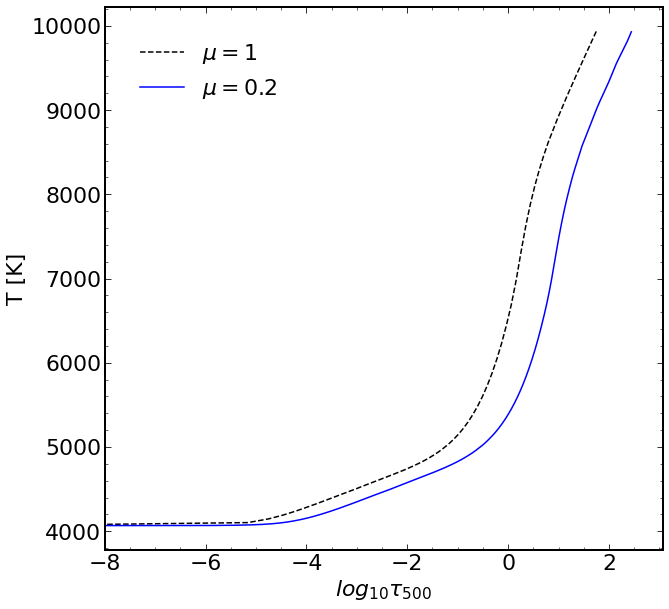

In [60]:
# matplotlib.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(np.log10(od_hav_1D) ,temp_hav_1D, label='$\mu = 1$', color='k' , linestyle='--')
ax.plot(np.log10(od_array_1D.ravel()/0.2), tt_array_1D.ravel(), label='$\mu = 0.2$', color='b' , linestyle='-')

ax.set_xlabel(r'$log_{10}\tau_{500}$')
# ax.set_ylim(3000,12000)
ax.set_xlim(-8)

ax.set_ylabel('T [K]')
ax.legend()
# fig.savefig('../plots/1D_temp_tau_adj.png')

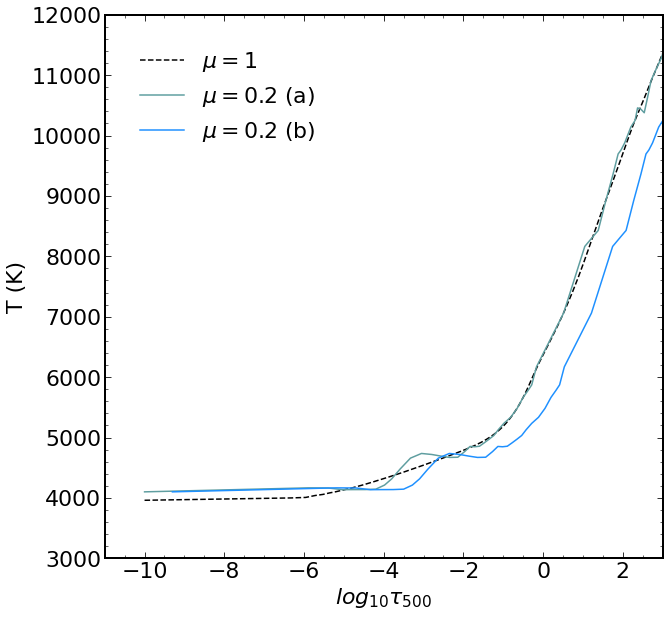

In [46]:
# matplotlib.rcParams.update({'font.size': 22})
# 3D 
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(np.log10(od_hav_3D), temp_hav_3D,  label='$\mu=1$', color='k' , linestyle='--')
ax.plot(np.log10(od_array_3D.ravel()), tt_array_3D.ravel(), label='$\mu = 0.2$ (a)', color='cadetblue' , linestyle='-')
ax.plot(np.log10(od_array_3D.ravel()/0.2), tt_array_3D.ravel(), label='$\mu = 0.2$ (b)', color='dodgerblue' , linestyle='-')


ax.set_xlabel(r'$log_{10}\tau_{500}$')
ax.set_ylim(3000,12000)
ax.set_xlim(-11,3)

ax.set_ylabel('T (K)')
ax.legend()
# fig.savefig('../plots/1D_temp_tau_adj.png')

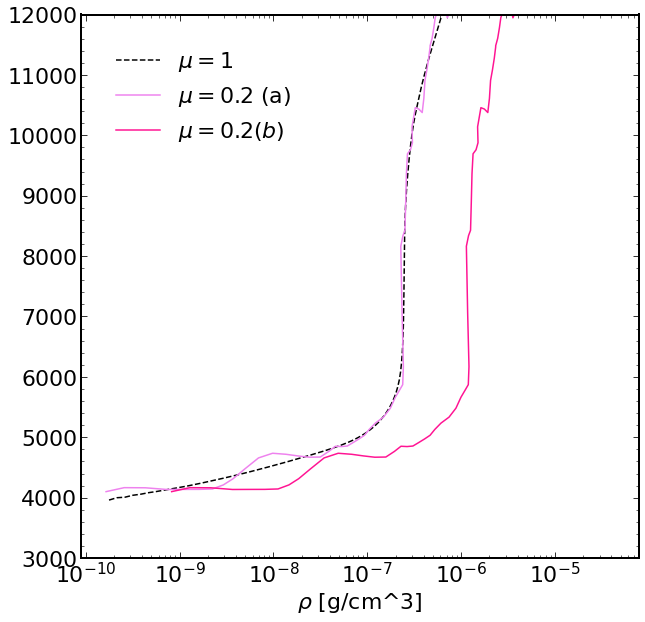

In [47]:
# 3D 
fig, ax = plt.subplots(1, figsize=(10,10))
ax.semilogx((rho_hav_3D), temp_hav_3D,  label='$\mu=1$', color='k' , linestyle='--')
ax.semilogx((rho_array_3D.ravel()), tt_array_3D.ravel(), label='$\mu = 0.2$ (a)', color='violet' , linestyle='-')
ax.semilogx((rho_array_3D.ravel()/0.2), tt_array_3D.ravel(), label='$\mu = 0.2 (b)$', color='deeppink' , linestyle='-')

ax.set_ylim(3000,12000)

ax.set_xlabel(r'$\rho$ [g/cm^3]')
ax.legend()
# fig.savefig('../plots/1D_temp_tau_adj.png')

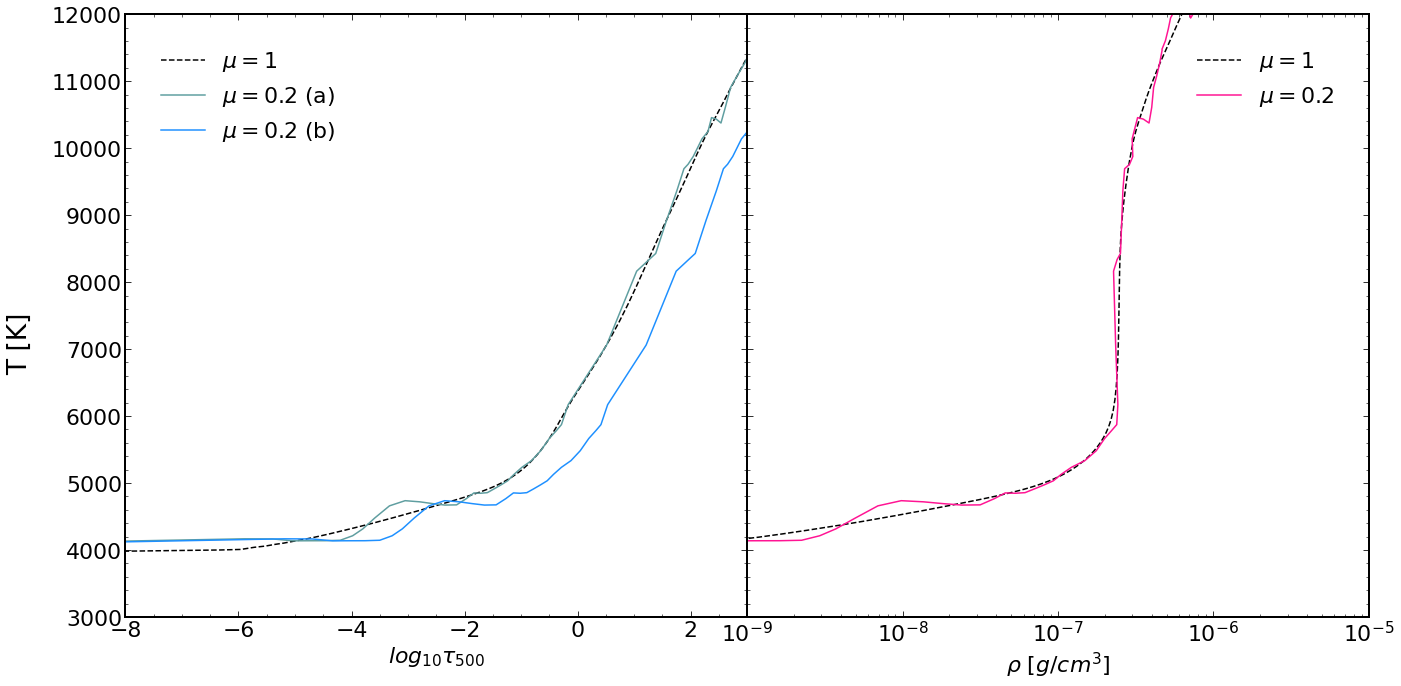

In [62]:
# 3D 
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharey=True)
ax[0].plot(np.log10(od_hav_3D), temp_hav_3D,  label='$\mu=1$', color='k' , linestyle='--')
ax[0].plot(np.log10(od_array_3D.ravel()), tt_array_3D.ravel(), label='$\mu = 0.2$ (a)', color='cadetblue' , linestyle='-')
ax[0].plot(np.log10(od_array_3D.ravel()/0.2), tt_array_3D.ravel(), label='$\mu = 0.2$ (b)', color='dodgerblue' , linestyle='-')


ax[0].set_xlabel(r'$log_{10}\tau_{500}$')
ax[0].set_ylim(3000,12000)
ax[0].set_xlim(-8,3)

# ax[0].set_ylabel('T (K)')
ax[0].legend()


ax[1].semilogx((rho_hav_3D), temp_hav_3D,  label='$\mu=1$', color='k' , linestyle='--')
ax[1].semilogx((rho_array_3D.ravel()), tt_array_3D.ravel(), label='$\mu = 0.2$', color='deeppink' , linestyle='-')
# ax[1].semilogx((rho_array_3D.ravel()/0.2), tt_array_3D.ravel(), label='$\mu = 0.2$ (b)', color='deeppink' , linestyle='-')
ax[1].set_xlabel(r'$\rho$ [$g$/$cm^3$]')

ax[1].set_xlim(1e-9,1e-5)
ax[1].legend()


fig.supylabel('T [K]')
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=None)
# fig.savefig('../plots/temp-depth-rho.png')


## Departure coefficients

In [49]:
# Read in NEW ABUNDANCE 3D NLTE spectra
run_3DNLTE_NEWAB = '../runs/SiStagNLTE_30_f3_7600abnd/output'
runobj_3DNLTE_NEWAB = m3d(run_3DNLTE_NEWAB, lines=[286], conts=[])

Completed reading parameters from ../runs/SiStagNLTE_30_f3_7600abnd/output/


In [50]:
dep_s = runobj_3DNLTE_NEWAB.depart(level=100)
mean_dep_s = np.mean(dep_s, axis=(0,1))
y_mean_tau500 = np.mean(np.log10(atmo_3DNLTE.tau), axis=(0,1))

(0.4, 1.4)

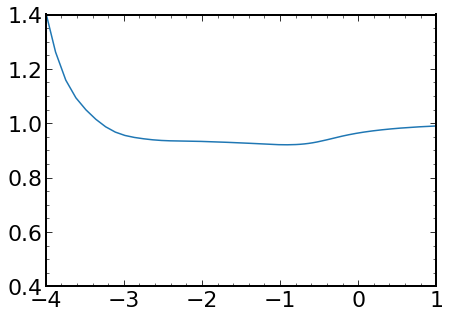

In [51]:
fig, ax = plt.subplots(1, figsize=(7,5))
ax.plot(y_mean_tau500, mean_dep_s)
ax.set_xlim(-4,1)
ax.set_ylim(0.4,1.4)


In [52]:
np.shape(atmo_3DNLTE.tau)

(30, 30, 230)

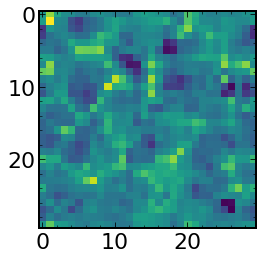

In [53]:
plt.imshow(atmo_3DNLTE.temp[:,:,0])

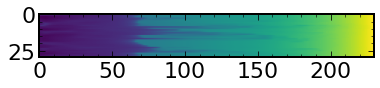

In [54]:
plt.imshow(atmo_3DNLTE.temp[:,0,:])